<a href="https://colab.research.google.com/github/mugash70/prediction_model/blob/main/ML_assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First Step: Importing the libraries needed for the task

In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import pydotplus
# from ann_visualizer.visualize import ann_viz 

In [146]:
df=pd.read_csv(r"/content/time_series_covid_19_confirmed.csv")
# df.sample(10)

In [147]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,58037,58214,58312,58542,58730,58843,59015,59225,59370,59576,59745,59939,60122,60300,60563,60797,61162,61455,61755,61842,62063,62403,62718,63045,63355,63412,63484,63598,63819,64122,64575,65080,65486,65728,66275,66903,67743,68366,69130,70111
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,129842,129980,130114,130270,130409,130537,130606,130736,130859,130977,131085,131185,131238,131276,131327,131419,131510,131577,131666,131723,131753,131803,131845,131890,131939,131978,132015,132032,132071,132095,132118,132153,132176,132209,132215,132229,132244,132264,132285,132297
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,119992,120174,120363,120562,120736,120922,121112,121344,121580,121866,122108,122311,122522,122717,122999,123272,123473,123692,123900,124104,124288,124483,124682,124889,125059,125194,125311,125485,125693,125896,126156,126434,126651,126860,127107,127361,127646,127926,128198,128456
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,12874,12917,12942,13007,13024,13060,13083,13121,13148,13198,13232,13232,13282,13295,13316,13340,13363,13390,13406,13423,13429,13447,13470,13470,13510,13510,13510,13555,13569,13569,13569,13569,13569,13569,13569,13664,13671,13682,13693,13693
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,24661,24883,25051,25279,25492,25609,25710,25942,26168,26431,26652,26815,26993,27133,27284,27529,27921,28201,28477,28740,28875,29146,29405,29695,30030,30354,30637,30787,31045,31438,31661,31909,32149,32441,32623,32933,33338,33607,33944,34180


In [182]:
 
kenya_data = df.loc[ df['Country/Region'] == 'Kenya']
confrimed_cases= kenya_data.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
print(confrimed_cases)

     1/22/20  1/23/20  1/24/20  1/25/20  ...  5/26/21  5/27/21  5/28/21  5/29/21
158        0        0        0        0  ...   169356   169697   170041   170485

[1 rows x 494 columns]


In [174]:
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from fbprophet import Prophet
import pycountry
import plotly.express as px
from collections import namedtuple

In [175]:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(confrimed_cases.values.T)
confrimed_cases = scaler.transform(confrimed_cases.values.T)

In [176]:
import numpy as np
X, y = [], []
# prediction based on 30 days and make accurate predition on the 31st
time_steps = 30
for i in range(len(confrimed_cases) - time_steps):
    x = confrimed_cases[i:(i+time_steps), 0]
    X.append(x)
    y.append(confrimed_cases[i+time_steps, 0])

X = np.array(X)
y = np.array(y)
#partion data
split = int(len(X) * 0.8)
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [181]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(Input(shape=(1, time_steps)))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(48))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))


model.compile(loss = 'mean_squared_error',
              optimizer = RMSprop(),
              metrics = ['mean_squared_error'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 48)             15168     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 48)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 48)             18624     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 48)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 48)                18624     
_________________________________________________________________
dropout_5 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [183]:
from keras.callbacks import ReduceLROnPlateau

batchsize = 100
epochs =  100

learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-10)

history = model.fit(X_train,
                    y_train,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks=[learning_rate_reduction])

Epoch 1/100
3/3 [==============================] - 6s 672ms/step - loss: 0.0376 - mean_squared_error: 0.0376 - val_loss: 0.2784 - val_mean_squared_error: 0.2784
Epoch 2/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0329 - mean_squared_error: 0.0329 - val_loss: 0.2500 - val_mean_squared_error: 0.2500
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.2200 - val_mean_squared_error: 0.2200
Epoch 4/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0256 - mean_squared_error: 0.0256 - val_loss: 0.1871 - val_mean_squared_error: 0.1871
Epoch 5/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - val_loss: 0.1520 - val_mean_squared_error: 0.1520
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.1156 - val_mean_squared_error: 0.1156
Epoch 7/100
3/3 [======================

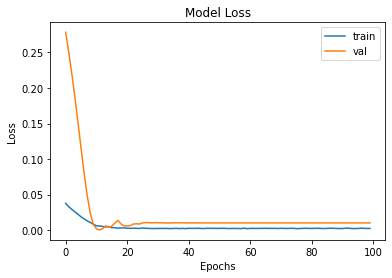

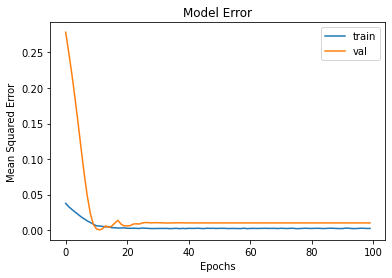

In [184]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

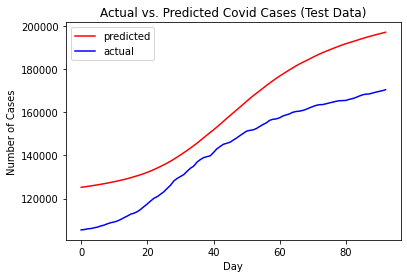

In [185]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

plt.plot(y_pred, color='red')
plt.plot(y_test, color='blue')
plt.title('Actual vs. Predicted Covid Cases (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])